In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from nilearn.image import resample_to_img
from nilearn.input_data import NiftiLabelsMasker
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
import nibabel as nib
from nilearn.plotting import find_xyz_cut_coords
from nilearn.image import math_img
from sklearn.externals.joblib import Memory
from nilearn import plotting
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline 
from sklearn.base import clone

# Preparation

## Dataset preparation

In [122]:
# Load BASC and create new parcellation with only connected label regions
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')['scale444']
from nilearn.regions import connected_label_regions
basc_regions = connected_label_regions(basc)
basc_data = basc_regions.get_data()
all_label=np.unique(basc_data)
n_reg=len(all_label)
all_labels = all_label[1:]
# Get coordinates & number of voxels of each region
allcoords=[]
basc_vox=[]
for i,curlabel in enumerate(all_labels):
    img_curlab = math_img(formula="img==%d"%curlabel,img=basc_regions)
    allcoords.append(find_xyz_cut_coords(img_curlab))
    basc_vox.append((basc_data==curlabel).sum())
allcoords=np.array(allcoords)
basc_vox=np.array(basc_vox)

# Load AAL SPM
from nilearn.datasets import fetch_atlas_aal
aal_atlas=fetch_atlas_aal(version='SPM12')
aal_label=np.array(aal_atlas.labels,dtype='S20')
aal_indices=np.array(aal_atlas.indices,dtype='f4')
aal_map=aal_atlas.maps

# Load MNI mask
brainmask = load_mni152_brain_mask()
# masker for plotting 
masker = NiftiLabelsMasker(labels_img = basc_regions, mask_img = brainmask, 
                           memory_level=1, verbose=0,
                           detrend=True, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels'
                           )
masker.fit()
# Load Motor Mask (created with WFU Pick Atlas - AAL) & resample
motor_mask='F:/IRM_Marche/masquesROI/mask_whole.nii'
mask_sh=resample_to_img(motor_mask,basc_regions)
mask_sh=math_img('img>0.2',img=mask_sh)
# The individual BOLD masked signal has been saved on local file - with confounds

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


## Select BASC regions included in a mask
New BASC parcellation without non connected regions

204


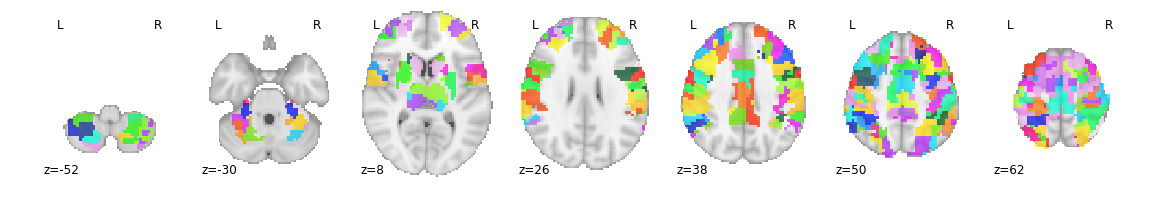

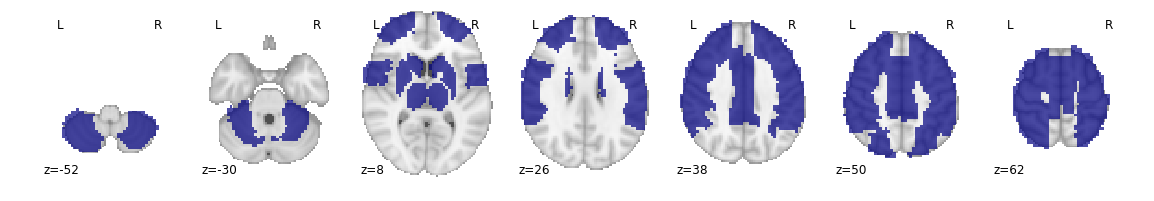

In [66]:
# Find Intersept of motor and new basc
m_intersept=math_img('img1*img2',img1=basc_regions,img2=mask_sh)

# We want to select the complete BASC regions that are included or overlap with the mask
#fetch all possible label values 
basc_motor = m_intersept.get_data()  
labels_motor = np.unique(basc_motor)
# remove the 0. value which correspond to voxels out of ROIs
labels_motor = labels_motor[1:]
# We identify the regions fully included in the mask or regions overlapping with at least 50% of the regions
labels_motor_final=[]
for i in labels_motor:
    reg_size=(basc_data==i).sum()
    reg_motor_size=(basc_motor==i).sum()
    if (reg_motor_size/reg_size)>0.5:
        labels_motor_final.append(i)
        #print(reg_size,reg_motor_size)
labels_motor_final=np.array(labels_motor_final,dtype=int)
print(len(labels_motor_final))
## Save label of the regions
#labels_motor_final.tofile('F:/IRM_Marche/masquesROI/reg_whole50_basc524asym.np')

 # Quality check
from nilearn.image import new_img_like
new_img=np.copy(basc_motor)
for k in range(len(labels_motor)):
    if k not in labels_motor_final:
        np.putmask(new_img,new_img==k,0)
basc_motor_img=new_img_like(basc,new_img)
plotting.plot_roi(basc_motor_img,display_mode='z',cut_coords=[-52,-30,8,26,38,50,62])
plotting.plot_roi(mask_sh,display_mode='z',cut_coords=[-52,-30,8,26,38,50,62])
#for i in labels_motor_final:
#    i=str(i)
#    plotting.plot_roi(math_img('img1=='+i,img1=basc_regions),title=i)

## Classification preparation

In [35]:
scaler = preprocessing.StandardScaler()
svm= SVC(C=1, kernel="linear")  
pipeline = Pipeline([('scale', scaler),('classif_name', svm)])
logo = LeaveOneGroupOut()
#logo=GroupKFold(n_splits=3)

In [36]:
# DEFINITION FOR PERMUTATION SCORE
def group_shuffle(y, groups):
    """Return a shuffled copy of y eventually shuffle among same groups."""

    indices = np.arange(len(groups))
    for group in np.unique(groups):
        this_mask = (groups == group)
        indices[this_mask] = np.random.permutation(indices[this_mask])
    return y[indices]

def test_score(estimator,X_cond_train,X_cond_test,y,groups,cv):
    result_score = []
    for train, test in cv.split(X_cond_train, y, groups):
        estimator.fit(X_cond_train[train], y[train])
        result_score.append(estimator.score(X_cond_test[test], y[test]))
    score=np.array(result_score).mean()
    return score,result_score, 


def permutation_score(estimator,X_cond_train,X_cond_test,y,groups,cv,n_permutations=1000):
    permutation_scores=[]
    score,result_score=test_score(clone(estimator),X_cond_train,X_cond_test,y,groups,cv)
    #n_split=3
    #kf=GroupKFold(n_splits=n_split)
    for n in range(n_permutations):
        tmp_scores,w = test_score(clone(estimator), X_cond_train,X_cond_test, 
                              group_shuffle(y, groups), groups, cv)
        permutation_scores.append(tmp_scores)

    permutation_scores = np.array(permutation_scores)        
    pvalue = np.sum(permutation_scores >= score) / (n_permutations)
    return score, permutation_scores, pvalue


## Load data

In [67]:
fold = 'F:/IRM_Marche/'
smt='ss'       
names=('ap','as','bh','bi','boh','cmp','cas','cs','cb','gm','gn','gbn',
       'mv','ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs')

# CREATE LABEL / COND
label=np.loadtxt(fold+'label_main.txt','S12')
block=np.loadtxt(fold+'block_main.txt','int')
# Remove first two volumes of each block
mask_block=block==block
for x in range(label.shape[0]):
    if label[x,2]!=label[x-1,2]:
        mask_block[x]=False
    elif label[x,2]!=label[x-2,2]:
        mask_block[x]=False
# Remove condition destructurée - not used for present study
c_des_out=np.logical_not(label[:,2]== b'des')
tmp_out= np.logical_and(c_des_out,mask_block)
# remove rest blocks
c_rest_out=np.logical_not(label[:,0]== b'rest')
cond_out= np.logical_and(tmp_out,c_rest_out)

cond_foot=np.logical_and(cond_out,label[:,1] == b'foot')
cond_hand=np.logical_and(cond_out,label[:,1] == b'hand')
cond_imag=np.logical_and(cond_out,label[:,0] == b'imag')
cond_stim=np.logical_and(cond_out,label[:,0] == b'stim')

y_foot=label[cond_foot,0]
y_hand=label[cond_hand,0]
y_imag=label[cond_imag,1]
y_stim=label[cond_stim,1]

# LOAD DATA AND GROUP ALL SUBJETS
roi_foot_all=np.zeros([0,len(labels_motor_final)])
roi_hand_all=np.zeros([0,len(labels_motor_final)])
roi_imag_all=np.zeros([0,len(labels_motor_final)])
roi_stim_all=np.zeros([0,len(labels_motor_final)])

y_foot_all=np.zeros(0)
y_hand_all=np.zeros(0)
y_imag_all=np.zeros(0)
y_stim_all=np.zeros(0)
groups=np.zeros(0)

for i,n in enumerate(sorted(names)):
    # Load masked data (all new basc)
    roi_name=fold+'mni4060/asym524roi_'+smt+'_'+n+'.npz'            
    roi=np.load(roi_name)['roi']
    # Only keep regions from the mask
    roi=roi[:,labels_motor_final-1]
    roi_foot=roi[cond_foot]
    roi_hand=roi[cond_hand]
    roi_imag=roi[cond_imag]
    roi_stim=roi[cond_stim]

    roi_foot_all=np.vstack((roi_foot_all,roi_foot))
    roi_hand_all=np.vstack((roi_hand_all,roi_hand))
    roi_imag_all=np.vstack((roi_imag_all,roi_imag))
    roi_stim_all=np.vstack((roi_stim_all,roi_stim))
    
    y_foot_all=np.append(y_foot_all,y_foot)
    y_hand_all=np.append(y_hand_all,y_hand)
    y_imag_all=np.append(y_imag_all,y_imag)
    y_stim_all=np.append(y_stim_all,y_stim)
    
    groups=np.append(groups,np.ones(len(y_foot))*i)


# ANALYSIS : Cross-validated Classification

In [62]:
result_foot,result_foot_all=test_score(pipeline,roi_foot_all,roi_foot_all,y_foot_all,groups,logo) 
result_hand,result_hand_all=test_score(pipeline,roi_hand_all,roi_hand_all,y_hand_all,groups,logo)
result_imag,result_imag_all=test_score(pipeline,roi_imag_all,roi_imag_all,y_imag_all,groups,logo)   
result_stim,result_stim_all=test_score(pipeline,roi_stim_all,roi_stim_all,y_stim_all,groups,logo)
result_t_foot,result_t_foot_all=test_score(pipeline,roi_foot_all,roi_hand_all,y_foot_all,groups,logo) 
result_t_hand,result_t_hand_all=test_score(pipeline,roi_hand_all,roi_foot_all,y_hand_all,groups,logo)
result_t_imag,result_t_imag_all=test_score(pipeline,roi_imag_all,roi_stim_all,y_imag_all,groups,logo)   
result_t_stim,result_t_stim_all=test_score(pipeline,roi_stim_all,roi_imag_all,y_stim_all,groups,logo)

from pandas import DataFrame
table=DataFrame(np.vstack((result_foot_all,result_hand_all,result_t_hand_all,result_t_foot_all,result_stim_all,result_imag_all,result_t_imag_all,result_t_stim_all)).T,columns=('foot','hand','CM test foot','CM test Hand','Stim','Imag','CM test Stim','CM test Imag'),index=sorted(names))
table.to_excel("C:/Users/mmenoret/Dropbox/Recherche/Articles/IRM_Marche/Papier 2/Accuracy_scores_newbasc70.xls")

In [ ]:
# CROSS MODAL CLASSIFICATION (cross-validated)
n_p=1000
result_cv_tr_foot,permutation_scores_tr_foot, p_foot=permutation_score(pipeline,roi_foot_all,roi_hand_all,y_foot_all,groups,logo,n_p) 
print('Train FOOT - IMAG VS STIM',np.array(result_cv_tr_foot).mean(),p_foot)
result_cv_tr_hand,permutation_scores_tr_hand, p_hand=permutation_score(pipeline,roi_hand_all,roi_foot_all,y_hand_all,groups,logo,n_p)
print('Train HAND - IMAG VS STIM',np.array(result_cv_tr_hand).mean(),p_hand)
result_cv_tr_imag,permutation_scores_tr_imag, p_imag=permutation_score(pipeline,roi_imag_all,roi_stim_all,y_imag_all,groups,logo,n_p)   
print('Train IMAG - HAND VS FOOT',np.array(result_cv_tr_imag).mean(),p_imag)
result_cv_tr_stim,permutation_scores_tr_stim, p_stim=permutation_score(pipeline,roi_stim_all,roi_imag_all,y_stim_all,groups,logo,n_p)
print('Train STIM - HAND VS FOOT',np.array(result_cv_tr_stim).mean(),p_stim)
##

# UNI MODAL CLASSIFICATION (cross-validated)
result_foot,permutation_scores_foot, p_foot=permutation_score(pipeline,roi_foot_all,roi_foot_all,y_foot_all,groups,logo,n_p) 
print('FOOT - IMAG VS STIM',np.array(result_foot).mean(),p_foot)
result_hand,permutation_scores_hand, p_hand=permutation_score(pipeline,roi_hand_all,roi_hand_all,y_hand_all,groups,logo,n_p)
print('HAND - IMAG VS STIM',np.array(result_hand).mean(),p_hand)
result_imag,permutation_scores_imag, p_imag=permutation_score(pipeline,roi_imag_all,roi_imag_all,y_imag_all,groups,logo,n_p)   
print('IMAG - HAND VS FOOT',np.array(result_imag).mean(),p_imag)
result_stim,permutation_scores_stim, p_stim=permutation_score(pipeline,roi_stim_all,roi_stim_all,y_stim_all,groups,logo,n_p)
print('STIM - HAND VS FOOT',np.array(result_stim).mean(),p_stim)


## SVM Weights visualisation and export

In [198]:
# Calculate coeficients on all data
pipeline.fit(roi_foot_all, y_foot_all)
coef_foot = pipeline.named_steps['classif_name'].coef_

pipeline.fit(roi_hand_all, y_hand_all)
coef_hand = pipeline.named_steps['classif_name'].coef_

pipeline.fit(roi_imag_all, y_imag_all)
coef_imag = pipeline.named_steps['classif_name'].coef_

pipeline.fit(roi_stim_all, y_stim_all)
coef_stim = pipeline.named_steps['classif_name'].coef_

# Threshold coeficients
def select_perc(array,perc):
    array_sum=np.abs(array.sum())
    #print(array_sum)
    #print(perc*array_sum)
    index_sorted=np.argsort(np.abs(array))[::-1]
    array_sorted=np.abs(array[index_sorted])
    cumulative = np.cumsum(array_sorted)
    #plt.figure()
   # plt.plot(cumulative)
    idx = (np.abs(cumulative-perc*array_sum)).argmin()
    #plt.axvline(idx,color='k')
    return idx,array_sorted[idx]
def select_max_r(array,sign,perc):
    new_array=array.copy()
    if 'p' in sign:
        array_sign=array.T[array.T>0]
        nb,th=select_perc(array_sign,perc)
        new_array[array<th]=0
    if 'n' in sign:
        array_sign=array.T[array.T<0]
        nb,th=select_perc(array_sign,perc)
        new_array[array>-th]=0
    print(th)
    return new_array
    
        
perc=0.9
coef_stim_p=select_max_r(coef_stim,'p',perc)
coef_stim_n=select_max_r(coef_stim,'n',perc)
coef_imag_p=select_max_r(coef_imag,'p',perc)
coef_imag_n=select_max_r(coef_imag,'n',perc)
coef_foot_p=select_max_r(coef_foot,'p',perc)
coef_foot_n=select_max_r(coef_foot,'n',perc)
coef_hand_p=select_max_r(coef_hand,'p',perc)
coef_hand_n=select_max_r(coef_hand,'n',perc)

coef_th_stim=coef_stim_p+coef_stim_n
coef_th_imag=coef_imag_p+coef_imag_n
coef_th_foot=coef_foot_p+coef_foot_n
coef_th_hand=coef_hand_p+coef_hand_n


0.0576628725868
0.0626244754818
0.0567984510364
0.0511282801145
0.0637200251275
0.0708268851639
0.0519095923478
0.056466767555


### Plot coeficients

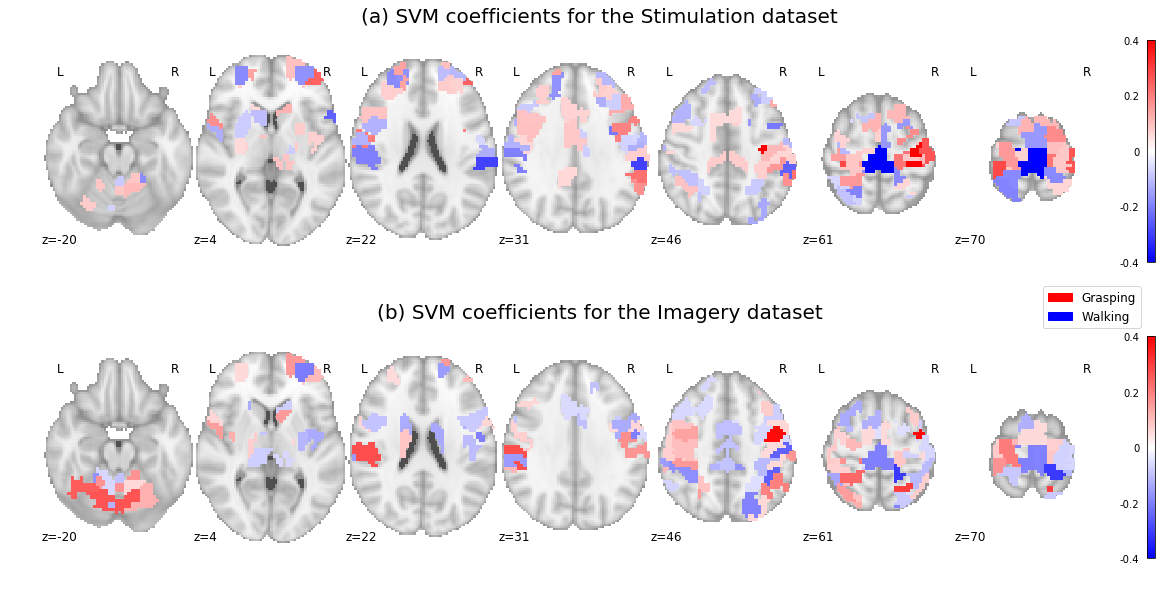

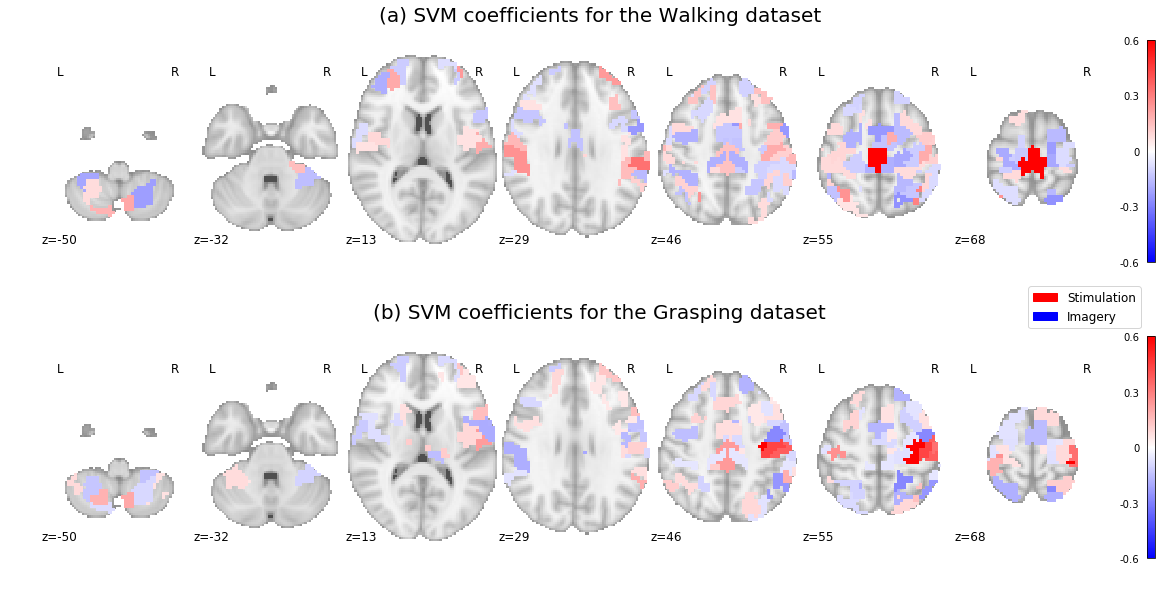

In [199]:


# Plot resulting weights of the SVM & selected regions
coef_tr_stim=np.zeros([1,n_reg])
coef_tr_imag=np.zeros([1,n_reg])
coef_tr_hand=np.zeros([1,n_reg])
coef_tr_foot=np.zeros([1,n_reg])
for i,n in enumerate(labels_motor_final):
    coef_tr_stim[0,n-1]=coef_th_stim[0,i]
    coef_tr_imag[0,n-1]=coef_th_imag[0,i]
    coef_tr_hand[0,n-1]=coef_th_hand[0,i]
    coef_tr_foot[0,n-1]=coef_th_foot[0,i]
from nilearn.plotting import plot_stat_map
weight_img_trstim = masker.inverse_transform(coef_tr_stim)
weight_img_trimag = masker.inverse_transform(coef_tr_imag)
weight_img_trhand = masker.inverse_transform(coef_tr_hand)
weight_img_trfoot = masker.inverse_transform(coef_tr_foot)

import matplotlib.pylab as plt
figure, (axes1, axes2) = plt.subplots(2, 1,figsize=(20,10))
plot_stat_map(weight_img_trstim, display_mode='z',cmap='bwr',axes=axes1,cut_coords=[-20,4,22,31,46,61,70],vmax=0.4)
axes1.set_title('(a) SVM coefficients for the Stimulation dataset',fontdict={'fontsize': 20})

plot_stat_map(weight_img_trimag, display_mode='z',cmap='bwr',axes=axes2,cut_coords=[-20,4,22,31,46,61,70],vmax=0.4)
axes2.set_title('(b) SVM coefficients for the Imagery dataset',fontdict={'fontsize': 20})
#plot_stat_map(weight_img_trimag,cmap='bwr')#, cut_coords=[-6, 6, 60])
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Grasping')
blue_patch= mpatches.Patch(color='blue', label='Walking')
plt.legend(handles=[red_patch,blue_patch],bbox_to_anchor=(0, 1.25),fontsize=12)
figure.savefig('C:/Users/mmenoret/Dropbox/Recherche/Articles/IRM_Marche/Papier 2/figure2.tiff')

figure, (axes1, axes2) = plt.subplots(2, 1,figsize=(20,10))
plot_stat_map(weight_img_trfoot, display_mode='z',cmap='bwr',axes=axes1,cut_coords=[-50,-32,13,29,46,55,68],vmax=0.6)
axes1.set_title('(a) SVM coefficients for the Walking dataset',fontdict={'fontsize': 20})

plot_stat_map(weight_img_trhand, display_mode='z',cmap='bwr',axes=axes2,cut_coords=[-50,-32,13,29,46,55,68],vmax=0.6)
axes2.set_title('(b) SVM coefficients for the Grasping dataset',fontdict={'fontsize': 20})
#plot_stat_map(weight_img_trimag,cmap='bwr')#, cut_coords=[-6, 6, 60])
red_patch = mpatches.Patch(color='red', label='Stimulation')
blue_patch= mpatches.Patch(color='blue', label='Imagery')
plt.legend(handles=[red_patch,blue_patch],bbox_to_anchor=(0, 1.25),fontsize=12)
figure.savefig('C:/Users/mmenoret/Dropbox/Recherche/Articles/IRM_Marche/Papier 2/figure4.tiff')

### Plot common coeficients

(36,)
(36,)


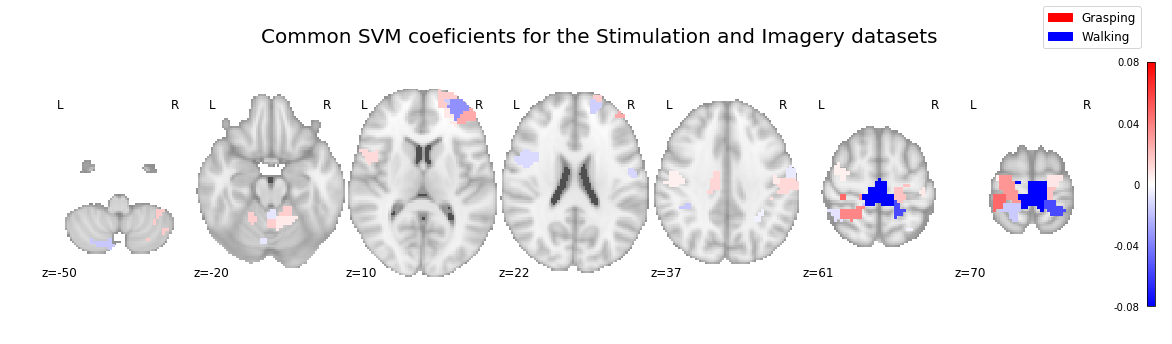

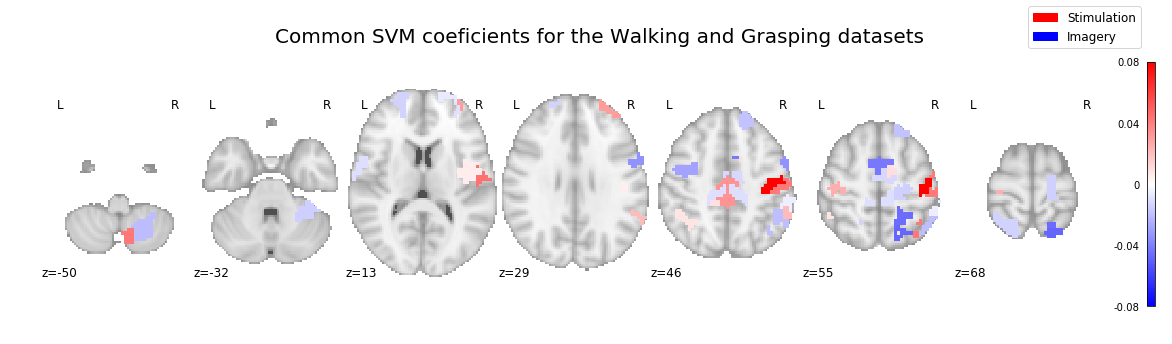

In [200]:
coef_tr_stim_pos=np.zeros([1,n_reg])
coef_tr_imag_pos=np.zeros([1,n_reg])
coef_tr_hand_pos=np.zeros([1,n_reg])
coef_tr_foot_pos=np.zeros([1,n_reg])
coef_tr_stim_neg=np.zeros([1,n_reg])
coef_tr_imag_neg=np.zeros([1,n_reg])
coef_tr_hand_neg=np.zeros([1,n_reg])
coef_tr_foot_neg=np.zeros([1,n_reg])
for i,n in enumerate(labels_motor_final):
    coef_tr_stim_pos[0,n-1]=coef_stim_p[0,i]
    coef_tr_stim_neg[0,n-1]=-coef_stim_n[0,i]
    coef_tr_imag_pos[0,n-1]=coef_imag_p[0,i]
    coef_tr_imag_neg[0,n-1]=-coef_imag_n[0,i]
    coef_tr_hand_pos[0,n-1]=coef_hand_p[0,i]
    coef_tr_hand_neg[0,n-1]=-coef_hand_n[0,i]
    coef_tr_foot_pos[0,n-1]=coef_foot_p[0,i]
    coef_tr_foot_neg[0,n-1]=-coef_foot_n[0,i]
    
# Commune
coef_common_HF=(coef_tr_stim_pos*coef_tr_imag_pos)-(coef_tr_stim_neg*coef_tr_imag_neg)
print(np.nonzero(coef_common_HF)[0].shape)
weight_common = masker.inverse_transform(coef_common_HF)
red_patch = mpatches.Patch(color='red', label='Grasping')
blue_patch= mpatches.Patch(color='blue', label='Walking')
figure, (axes1) = plt.subplots(1, 1,figsize=(20,5))
plot_stat_map(weight_common,display_mode='z',cmap='bwr',axes=axes1,vmax=0.08,cut_coords=[-50,-20,10,22,37,61,70])
axes1.set_title('Common SVM coeficients for the Stimulation and Imagery datasets',fontdict={'fontsize': 20})
plt.legend(handles=[red_patch,blue_patch],bbox_to_anchor=(0, 1.25),fontsize=12)
figure.savefig('C:/Users/mmenoret/Dropbox/Recherche/Articles/IRM_Marche/Papier 2/figure3.tiff')

coef_common_IS=(coef_tr_hand_pos*coef_tr_foot_pos)-(coef_tr_hand_neg*coef_tr_foot_neg)
print(np.nonzero(coef_common_IS)[0].shape)
weight_common = masker.inverse_transform(coef_common_IS)
red_patch = mpatches.Patch(color='red', label='Stimulation')
blue_patch= mpatches.Patch(color='blue', label='Imagery')
figure, (axes1) = plt.subplots(1, 1,figsize=(20,5))
#plot_stat_map(weight_common,cmap='bwr',axes=axes1,vmax=0.08,cut_coords=[57,-25,12])
plot_stat_map(weight_common,display_mode='z',cmap='bwr',axes=axes1,vmax=0.08,cut_coords=[-50,-32,13,29,46,55,68])
axes1.set_title('Common SVM coeficients for the Walking and Grasping datasets',fontdict={'fontsize': 20})
plt.legend(handles=[red_patch,blue_patch],bbox_to_anchor=(0, 1.25),fontsize=12)
figure.savefig('C:/Users/mmenoret/Dropbox/Recherche/Articles/IRM_Marche/Papier 2/figure5.tiff')


### Export coordinates and regions

In [201]:
import pandas as pd
from nilearn import input_data

filelist={'compHANDFOOT_trainSTIM':coef_tr_stim,
          'compHANDFOOT_trainIMAG':coef_tr_imag,
          'compHANDFOOT_COMMON':coef_common_HF,
          'compIMAGSTIM_trainHAND':coef_tr_hand,
          'compIMAGSTIM_trainFOOT':coef_tr_foot,
          'compIMAGSTIM_COMMON':coef_common_IS,
          }
writer = pd.ExcelWriter('C:/Users/mmenoret/Dropbox/Recherche/Articles/IRM_Marche/Papier 2/result_f85.xlsx')
for name,coef in sorted(filelist.items()):
    coef=coef[:,:-1]
    mask=np.array(coef!=0).squeeze()
    all_labels.reshape((all_labels.shape[0],1))
    basc_n=all_labels[mask]
    basc_n=basc_n.reshape((basc_n.shape[0],1))
    n_vox=basc_vox[mask]
    n_vox=n_vox.reshape((n_vox.shape[0],1))
    coord=np.round(allcoords[mask])
    spheres_masker = input_data.NiftiSpheresMasker(seeds=coord)
    aal_value = spheres_masker.fit_transform(aal_map)
    label=[]
    for index in aal_value.T:
        if index == 0:
            label.append(np.array((['none']),dtype=str))         
        else:
            label.append(aal_label[aal_indices==int(index)])
    label=np.array(label)

    coef_f=(coef.T)[mask]
    final=np.hstack((basc_n,n_vox,label,coord,coef_f))
    data=pd.DataFrame(final,columns=('524 BASC region','Region size (in voxel)','Anatomical region','X','Y','Z','SVM coefficient'),dtype=str)   
    data.to_excel(writer,sheet_name=name,index=False)
writer.close()